# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Schedule:
- Checkpoint Submission (DUE 03 October 2025 @ 11:59PM EST)
- Kaggle Submission (DUE 10 October 2025 @ 11:59PM EST | Slack Deadline is 17 October 2025 @ 11:59PM EST)
- Code Submission (DUE 12 October 2025 @ 11:59PM EST OR Day-of Slack submission)


## Requirement Acknowledgement
Setting the below flag to True indicates full understanding and acceptance of the following:
1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
3. We will require your kaggle username here, and then we will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
   You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.

In [105]:
ACKNOWLEDGED = False #TODO: Only set Acknowledged to True if you have read the above acknowlegements and agree to ALL of them.

## Welcome to the World of Convolutions!
In the previous homework, you learned about Multi-Layer Perceptrons (MLPs), the foundation of deep learning. MLPs demonstrated how networks could learn to predict phonemes from speech data, understand patterns, and even approximate complex functions. However, as powerful as MLPs are, they can struggle when dealing with image data. Flattening images into 1D vectors loses spatial information, like how pixels relate to one another. That’s where Convolutional Neural Networks (CNNs) step in, preserving these relationships and taking us one step closer to designing models that "see" the world as we do.

In this homework, you’ll explore CNNs by working on face classification and verification tasks. Imagine training a model to identify a face from a set of known identities (classification) and then using the same model to decide whether two face images belong to the same person (verification).

For example, given a photo of your friend and a group photo, the classifier would identify your friend’s name, while the verifier would confirm whether two photos depict the same person, even if the person wasn’t part of the training data. CNNs make this possible by extracting hierarchical features from images—from edges and corners in early layers to complex patterns like facial features in deeper layers.

To succeed, you’ll need to understand the nuances of loss functions. Classification relies on Cross-Entropy Loss, which optimizes the model to predict the correct label. For verification, however, we care about embedding similarity. This is where Triplet Loss or** ArcFace Loss** comes in, pushing embeddings of the same person closer together while separating those of different individuals. For instance, a good verification system would ensure that photos of two siblings (often visually similar) are distinguishable in the embedding space, all while being robust to lighting or pose differences.

This homework will also emphasize the practical skills needed for real-world deep learning. You’ll preprocess images, apply data augmentation like flipping or cropping to make the model robust to shifts in the images, and experiment with CNN architectures such as ResNet or ConvNeXt. Along the way, you’ll see how designing a model for classification doesn’t automatically make it suitable for verification, teaching you the importance of aligning task objectives with the right loss function. By the end, you’ll have built a robust system that mimics cutting-edge face recognition applications, from unlocking smartphones to verifying IDs. Let’s take this exciting leap together!

# **SET-UP**


Join the kaggle competition first (https://www.kaggle.com/t/93e12fee620b40d7a82990b9fe1815c7)

## **Colab Users**

#### Step 1: Environment Setup

In [106]:
## Config environment

KAGGLE=True
COLLAB=False
PSC=False
AWS=False
LOCAL=False


In [107]:
!nvidia-smi # Run this to see what GPU you have

Fri Oct  3 22:25:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             33W /   70W |     103MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [108]:
if COLLAB and "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [109]:
if COLLAB and os.path.exists("/content"):
    %cd /content
    !pwd

In [110]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet # Install the Pytorch Metric Library
!pip install torchinfo --quiet # Install torchinfo

#### Step 2: Get Data

In [111]:
if COLLAB:
    # TODO: Use the same Kaggle code from HW2P2
    !pip install --upgrade --force-reinstall --no-deps kaggle==1.7.4.2 --quiet
    !mkdir /root/.kaggle

    with open("/root/.kaggle/kaggle.json", "w+") as f:
        f.write('{"username":"todo-kaggle username","key":"todo-kaggle key"}')
        # Put your kaggle username & key here

    !chmod 600 /root/.kaggle/kaggle.json
    

In [112]:
# # Reminder: Make sure you have connected your kaggle API before running this block
# !mkdir '/content/data'
if COLLAB:
    !kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2025
    !unzip -qo '11785-hw-2-p-2-face-verification-fall-2025.zip' -d 'data'

## **Kaggle Users**



#### Step 1: Environment Setup

In [113]:
!pwd

/kaggle/working


In [114]:
if KAGGLE:
    !pip install wandb --quiet # Install WandB
    !pip install pytorch_metric_learning --quiet # Install the Pytorch Metric Library
    !pip install torchinfo --quiet # Install torchinfo

#### Step 2: Get Data

If you are using Kaggle, follow these steps to add the dataset directly to your notebook:
1. Join the kaggle competition (https://www.kaggle.com/t/93e12fee620b40d7a82990b9fe1815c7)
2. Open your **Kaggle Notebook**.  
3. Navigate to **Notebook → Input**.  
4. Click **Add Input**.  
5. Choose "Competition Datasets" and "Your work", and then you'll be able to see the competiation "11785-hw-2-p-2-face-verification-fall-2025"
6. Click the **➕ (plus sign)** to add the dataset to your notebook.  

## **PSC Users**

### 1️⃣ **Step 1 Setting Up Your Environment on Bridges2**

❗️⚠️ For this homework, we are **providing shared Datasets and a shared Conda environment** for the entire class.

❗️⚠️ So for PSC users, **do not download the data yourself** and **do not need to manually install the packages**!

Follow these steps to set up the environment and start a Jupyter notebook on Bridges2:

To run your notebook more efficiently on PSC, we need to use a **Jupyter Server** hosted on a compute node.

You can use your prefered way of connecting to the Jupyter Server.



**The recommended way of connecting is:**

#### **Connect in VSCode**
SSH into Bridges2 and navigate to your **Jet directory** (`Jet/home/<your_username>`). Upload your notebook there, and then connect to the Jupyter Server from that directory.

#### **1. SSH into Bridges2**
1）Open VS Code and click on the `Extensions` icon in the left sidebar. Make sure the "**Remote - SSH**" extension is installed.

2）Open the command palette (**Shift+Command+P** on Mac, **Ctrl+Shift+P** on Windows). A search box will appear at the top center. Choose `"Remote-SSH: Add New SSH Host"`, then enter:

```bash
ssh <your_username>@bridges2.psc.edu #change <your_username> to your username
```

Next, choose `"/Users/<your_username>/.ssh/config"` as the config file. A dialog will appear in the bottom right saying "Host Added". Click `"Connect"`, and then enter your password.

(Note: After adding the host once, you can later use `"Remote-SSH: Connect to Host"` and select "bridges2.psc.edu" from the list.)

3）Once connected, click `"Explorer"` in the left sidebar > "Open Folder", and navigate to your home directory under the project grant:
```bash
/jet/home/<your_username>  #change <your_username> to your username
```

4）You can now drag your notebook files directly into the right-hand pane (your remote home directory), or upload them using `scp` into your folder.

> ❗️⚠️ The following steps should be executed in the **VSCode integrated terminal**.

#### **2. Navigate to Your Directory**
Make sure to use this `/jet/home/<your_username>` as your working directory, since all subsequent operations (up to submission) are based on this path.
```bash
cd /jet/home/<your_username>  #change <your_username> to your username
```

#### **3. Request a Compute Node**
```bash
interact -p GPU-shared --gres=gpu:v100-32:1 -t 8:00:00 -A cis250019p
```

#### **4. Load the Anaconda Module**
```bash
module load anaconda3
```

#### **5. Activate the provided HW2 Environment**
```bash
conda deactivate # First, deactivate any existing Conda environment
conda activate /ocean/projects/cis250019p/mzhang23/TA/HW2P2/envs/hw2p2_env && export PYTHONNOUSERSITE=1
```

#### **6. Start Jupyter Notebook**
Launch Jupyter Notebook:
```bash
jupyter notebook --no-browser --ip=0.0.0.0
```

Go to **Kernel** → **Select Another Kernel** → **Existing Jupyter Server**
   Enter the URL of the Jupyter Server:```http://{hostname}:{port}/tree?token={token}```
   
   *(Usually, this URL appears in the terminal output after you run `jupyter notebook --no-browser --ip=0.0.0.0`, in a line like:  “Jupyter Server is running at: http://...”)*

   - eg: `http://v011.ib.bridges2.psc.edu:8888/tree?token=e4b302434e68990f28bc2b4ae8d216eb87eecb7090526249`

> **Note**: Replace `{hostname}`, `{port}` and `{token}` with your actual values from the Jupyter output.

#### **7. Navigate to Your Jet Directory**

After launching the Jupyter notebook, you can run the cells directly inside the notebook — no need to use the terminal for the remaining steps.

First, navigate to your **Jet directory** (`/jet/home/<your_username>`).

️❗️⚠ Please make sure to use your **Jet directory**, not the **Ocean path** — **all HW setup and outputs below are based on this directory**.

In [115]:
if PSC:
    #Make sure you are in your directory
    !pwd #should be /jet/home/<your_username>, if not, uncomment the following line and replace with your actual username:
    %cd /jet/home/<your_username>  #TODO: replace the "<your_username>" to yours

### 2️⃣ **Step 2: Set up Kaggle API Authentication**

In [116]:
if PSC:
    # TODO: Use the same Kaggle code from HW2P2
    !mkdir /jet/home/<your_username>/.kaggle #TODO: replace the "<your_username>" to yours

    with open("/jet/home/<your_username>/.kaggle/kaggle.json", "w+") as f: #TODO: replace the "<your_username>" to yours
        f.write('{"username":"<your_username>","key":"<your_key>"}')
        # TODO: Put your kaggle username & key here

    !chmod 600 /jet/home/<your_username>/.kaggle/kaggle.json #TODO: replace the "<your_username>" to yours

### 3️⃣ **Step 3: Get Data**

❗️⚠️ The data used in this assignment is **already stored in a shared, read-only folder, so you do not need to manually download anything**.

Instead, just make sure to replace the dataset path in your notebook code with the correct path from the shared directory.

You can run the following block to explore the shared directory structure:

In [117]:
if PSC:
    import os
    data_path = "/ocean/projects/cis250019p/mzhang23/TA/HW2P2/hw2p2_data/hw2p2_puru_aligned" #Shared data path, do not need to change the username to yours
    print("Files in shared hw2p2 dataset:", os.listdir(data_path))

In [118]:
if PSC:
    !apt-get install tree
    !tree -L 2 /ocean/projects/cis250019p/mzhang23/TA/HW2P2/hw2p2_data/hw2p2_puru_aligned

# Imports

In [119]:
import torch
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import gc
# from tqdm import tqdm
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


# Config

### Notes:

- You will need to set the root path to your `hw2p2_data` folder in `data: root:`. This will depend on your setup. For eg. if you are following out setup instruction:
  - `Colab:`: `"/content/data/hw2p2_puru_aligned"`
  - `Kaggle:`: `"/kaggle/input/11785-hw-2-p-2-face-verification-fall-2025/hw2p2_puru_aligned"`
  - `PSC`: `"/ocean/projects/cis250019p/mzhang23/TA/HW2P2/hw2p2_data/hw2p2_puru_aligned"`

Kindly modify your configurations to suit your ablations and be keen to include your name.

In [120]:
config = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 0.1,
    'epochs': 20, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'num_classes': 8631, #Dataset contains 8631 classes for classification, reduce this number if you want to train on a subset, but only for train dataset and not on val dataset
    'root': "/kaggle/input/11785-hw-2-p-2-face-verification-fall-2025/hw2p2_puru_aligned",
    'cls_data_dir': "cls_data", #TODO: Provide path of classification directory
    'ver_data_dir': "ver_data", #TODO: Provide path of verification directory
    'val_pairs_file': "val_pairs.txt", #TODO: Provide path of text file containing val pairs for verification
    'test_pairs_file': "test_pairs.txt", #TODO: Provide path of text file containing test pairs for verification
    'checkpoint_dir': "/kaggle/output", #TODO: Checkpoint directory
    'augument': False,
    'h_flip_prob': 0.25,
    'rand_persp_prob': 0.33
    # Include other parameters as needed.
}

# Dataset

In [121]:
def create_transforms(image_size: int = 112, augment: bool = True) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),

        # Convert PIL Image to tensor
        T.ToTensor(),

        # Convert image to float32 and scale the pixel values to [0, 1]
        T.ToDtype(torch.float32, scale=True),
    ]

    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        # TODO: Add transformations for data augmentation (e.g., random horizontal flip, rotation, etc.)
        # HINT: What transforms help faces look more varied?
        # Think: Does a horizontally flipped face still look like the same person?
        # What about small rotations or color changes?
        # Example:
        transform_list.extend([
            # T.RandomHorizontalFlip(config["h_flip_prob"]),
            # T.RandomPerspective(p = config["random_persp_prob"][0], distortion_scale=config["random_persp_prob"][1])
        ])

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)


## Classification Datasets and Dataloaders

In [122]:
class ImageDataset(torch.utils.data.Dataset):
    """Custom dataset for loading image-label pairs."""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        """
        Args:
            root (str): Path to the directory containing the images folder.
            transform (callable): Transform to be applied to the images.
            num_classes (int, optional): Number of classes to keep. If None, keep all classes.
        """
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()

        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        lines = sorted(lines, key=lambda x: int(x.strip().split(' ')[-1]))

        # Get all unique labels first
        all_labels = sorted(set(int(line.strip().split(' ')[1]) for line in lines))

         # Select subset of classes if specified
        if num_classes is not None:
            selected_classes = set(all_labels[:num_classes])
        else:
            selected_classes = set(all_labels)

        # Store image paths and labels with a progress bar
        for line in tqdm(lines, desc="Loading dataset"):
            img_path, label = line.strip().split(' ')
            label = int(label)

            # Only add if label is in selected classes
            if label in selected_classes:
                self.image_paths.append(os.path.join(self.root, 'images', img_path))
                self.labels.append(label)
                self.classes.add(label)

        assert len(self.image_paths) == len(self.labels), "Images and labels mismatch!"

        # Convert classes to a sorted list
        self.classes = sorted(self.classes)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image, label)
        """
        # Load and transform image on-the-fly
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

gc.collect()

7401

In [123]:
# train transforms
train_transforms = create_transforms(augment=config['augument'])

# val transforms
val_transforms   = create_transforms(augment=False)

In [124]:
import os
import sys


if not os.path.exists(config['root']):
    raise ValueError(f"Path <<{config['root']}>> is not valid")

# Datasets
cls_train_dataset = ImageDataset(f"{config['root']}/{config['cls_data_dir']}/train", train_transforms)
# HINT: What dataset class do you use? What folder has your training data?
# What transforms should training data use?

cls_val_dataset   = ImageDataset(f"{config['root']}/{config['cls_data_dir']}/dev", val_transforms)
# HINT: Same dataset class, but what folder for validation?
# Should validation use augmentation transforms?

cls_test_dataset  = ImageDataset(f"{config['root']}/{config['cls_data_dir']}/test", val_transforms)
# HINT: What's the pattern here? What folder contains test data?

assert cls_train_dataset.classes == cls_val_dataset.classes == cls_test_dataset.classes, "Class mismatch!"


# Dataloaders
cls_train_loader = DataLoader(cls_train_dataset, batch_size=config['batch_size'], shuffle=True,  num_workers=4, pin_memory=True)
cls_val_loader   = DataLoader(cls_val_dataset,   batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
cls_test_loader  = DataLoader(cls_test_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

Loading dataset:   0%|          | 0/431550 [00:00<?, ?it/s]

Loading dataset:   0%|          | 0/43155 [00:00<?, ?it/s]

Loading dataset:   0%|          | 0/43155 [00:00<?, ?it/s]

## Verification Dataset and Datatloaders

In [125]:
class ImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.matches     = []
        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2, match = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)
            self.matches.append(int(match))  # Convert match to integer

        assert len(self.image1_list) == len(self.image2_list) == len(self.matches), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        match = self.matches[idx]
        return self.transform(img1), self.transform(img2), match


In [126]:
class TestImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2 = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)

        assert len(self.image1_list) == len(self.image2_list), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        return self.transform(img1), self.transform(img2)


In [127]:
# Datasets
ver_val_dataset  = ImagePairDataset(f'{config["root"]}/ver_data', f'{config["root"]}/val_pairs.txt', val_transforms)
# HINT: What dataset class handles image pairs? What file lists the validation pairs?

ver_test_dataset = TestImagePairDataset(f'{config["root"]}/ver_data', f'{config["root"]}/test_pairs.txt', val_transforms)
# HINT: Same class, but what file has test pairs? Does it include labels?

# Dataloader
ver_val_loader   = DataLoader(ver_val_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
ver_test_loader  = DataLoader(ver_test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)


Loading image pairs:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading image pairs:   0%|          | 0/6000 [00:00<?, ?it/s]

## Create Dataloaders for Image Recognition

# EDA and Viz

In [128]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(cls_train_dataset.classes))
print("No. of train images  : ", cls_train_dataset.__len__())
print("Shape of image       : ", cls_train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", cls_train_loader.__len__())
print("Val batches          : ", cls_val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  64
Train batches        :  6743
Val batches          :  675


###Classification Dataset Viz

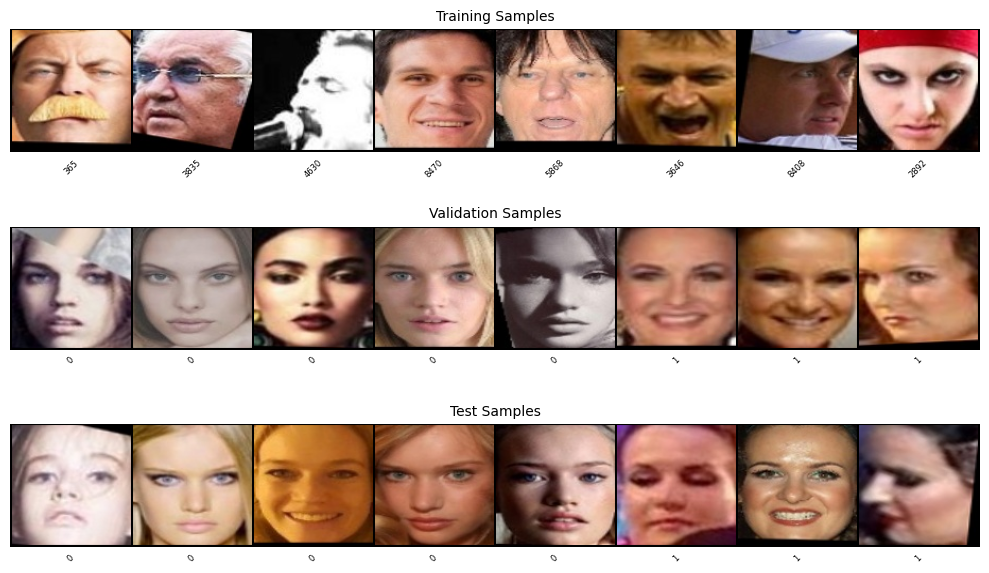

In [129]:
def show_cls_dataset_samples(train_loader, val_loader, test_loader, samples_per_set=8, figsize=(10, 6)):
    """
    Display samples from train, validation, and test datasets side by side

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        samples_per_set: Number of samples to show from each dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n]

    # Get samples from each dataset
    train_imgs, train_labels = get_samples(train_loader, samples_per_set)
    val_imgs, val_labels = get_samples(val_loader, samples_per_set)
    test_imgs, test_labels = get_samples(test_loader, samples_per_set)

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot each dataset
    for idx, (imgs, labels, title) in enumerate([
        (train_imgs, train_labels, 'Training Samples'),
        (val_imgs, val_labels, 'Validation Samples'),
        (test_imgs, test_labels, 'Test Samples')
    ]):

        # Create grid of images
        grid = make_grid(denormalize(imgs), nrow=8, padding=2)

        # Display grid
        axes[idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=10)

        # Add class labels below images (with smaller font)
        grid_width = grid.shape[2]
        imgs_per_row = min(8, samples_per_set)
        img_width = grid_width // imgs_per_row

        for i, label in enumerate(labels):
            col = i % imgs_per_row  # Calculate column position
            if label<len(train_loader.dataset.classes):
              class_name = train_loader.dataset.classes[label]
            else:
              class_name = f"Class {label} (Unknown)"
            axes[idx].text(col * img_width + img_width/2,
                         grid.shape[1] + 5,
                         class_name,
                         ha='center',
                         va='top',
                         fontsize=6,
                         rotation=45)

    plt.tight_layout()
    plt.show()

show_cls_dataset_samples(cls_train_loader, cls_val_loader, cls_test_loader)

###Ver Dataset Viz

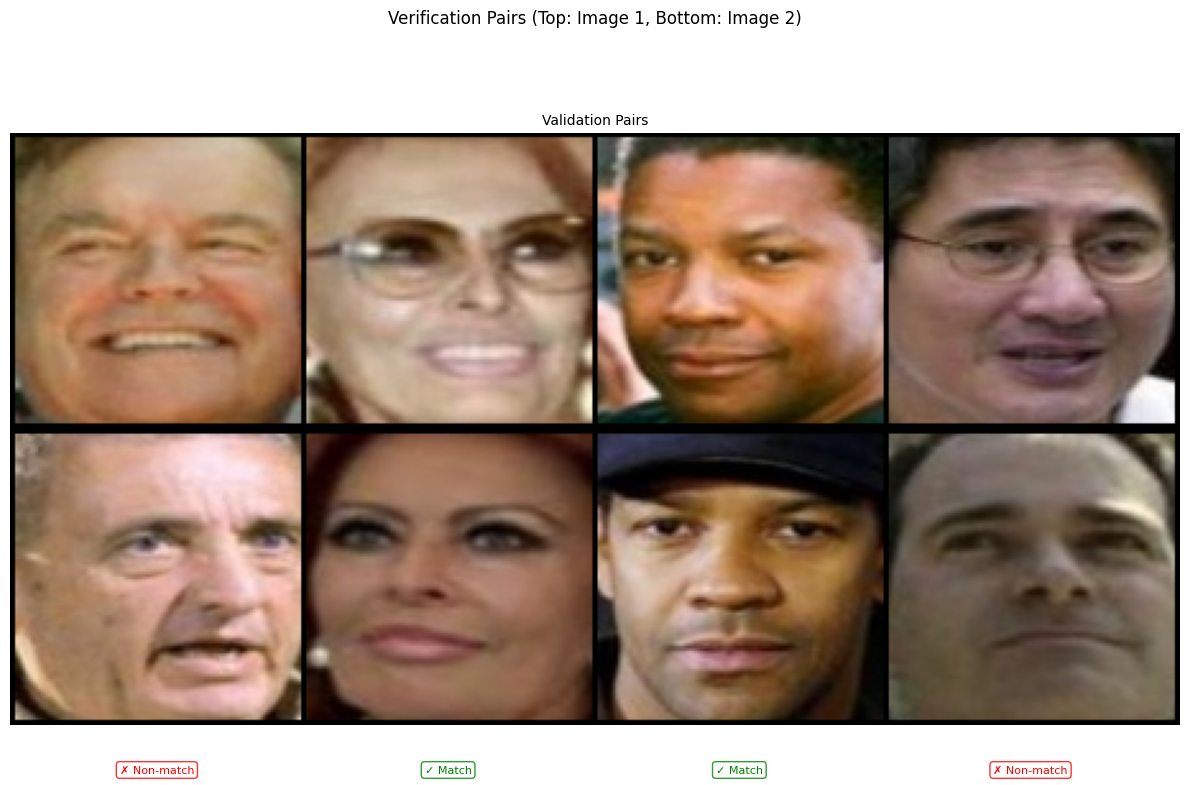

In [130]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_ver_dataset_samples(val_loader, samples_per_set=4, figsize=(12, 8)):
    """
    Display verification pairs from the validation dataset

    Args:
        val_loader: Validation data loader
        samples_per_set: Number of pairs to show from the dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n], batch[2][:n]

    # Get samples from the validation dataset
    val_imgs1, val_imgs2, val_labels = get_samples(val_loader, samples_per_set)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Create grids for both images in each pair
    grid1 = make_grid(denormalize(val_imgs1), nrow=samples_per_set, padding=2)
    grid2 = make_grid(denormalize(val_imgs2), nrow=samples_per_set, padding=2)

    # Combine the grids vertically
    combined_grid = torch.cat([grid1, grid2], dim=1)

    # Display the combined grid
    ax.imshow(combined_grid.permute(1, 2, 0).cpu())
    ax.axis('off')
    ax.set_title('Validation Pairs', fontsize=10)

    # Determine dimensions for placing the labels
    grid_width = grid1.shape[2]
    img_width = grid_width // samples_per_set

    # Add match/non-match labels for each pair
    for i, label in enumerate(val_labels):
        match_text = "✓ Match" if label == 1 else "✗ Non-match"
        color = 'green' if label == 1 else 'red'

        # Define a background box for the label
        bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec=color,
            alpha=0.8
        )

        ax.text(i * img_width + img_width / 2,
                combined_grid.shape[1] + 15,  # Position below the images
                match_text,
                ha='center',
                va='top',
                fontsize=8,
                color=color,
                bbox=bbox_props)

    plt.suptitle("Verification Pairs (Top: Image 1, Bottom: Image 2)", y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

show_ver_dataset_samples(ver_val_loader)

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit for this homework is 30M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [131]:
# TODO: Fill out the model definition below

class Network(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.backbone = torch.nn.Sequential( #112x112
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=4, padding=3, padding_mode="zeros"), #
            # torch.nn.AdaptiveAvgPool2D((54, 54)),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, padding_mode="zeros"), #
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            # torch.nn.AdaptiveMaxPool2D((25, 25)),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, padding_mode="zeros"),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            # torch.nn.AdaptiveMaxPool2D((25, 25)),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1, padding_mode="zeros"),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=2, padding=1, padding_mode="zeros"),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten(),
            )

        self.cls_layer = torch.nn.Linear(in_features=1024, out_features=num_classes)
                                            

    def forward(self, x):

        feats = self.backbone(x)
        out = self.cls_layer(feats)

        return {"feats": feats, "out": out}

# Initialize your model
model = Network(num_classes=config['num_classes']).to(DEVICE)
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           9,472
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
       BatchNorm2d-5          [-1, 128, 14, 14]             256
              ReLU-6          [-1, 128, 14, 14]               0
            Conv2d-7            [-1, 256, 7, 7]         295,168
       BatchNorm2d-8            [-1, 256, 7, 7]             512
              ReLU-9            [-1, 256, 7, 7]               0
           Conv2d-10            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
             ReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13           [-1, 1024, 2, 2]       4,719,616
      BatchNorm2d-14           [-1, 102

In [132]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss()

# --------------------------------------------------- #

# Defining Optimizer
optimizer =  torch.optim.AdamW(model.parameters())

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_36/3269402090.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [133]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [134]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [135]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [136]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step(loss.item())

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [137]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [138]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [139]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC']

# WandB

In [140]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("WANDB_API")

wandb.login(key=wandb_api) # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ranais (mrsd-smores) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [141]:
# Create your wandb run
run = wandb.init(
    name = "early-submission", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ranais", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [142]:
wandb.save("all")

[]

# Checkpointing and Loading Model

In [143]:
import os
checkpoint_dir = config['checkpoint_dir']

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [144]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, cls_train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, cls_val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, ver_val_loader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/20


Train:   0%|          | 0/6743 [00:00<?, ?it/s]

/tmp/ipykernel_36/1107181305.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!


# Testing and Kaggle Submission

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, ver_test_loader, config)

In [ ]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
### Finish your wandb run
run.finish()

**For Kaggle users:**

You'll find the "**verification_submission.csv**" under the **right sidebar → Output → kaggle/working/**.
If you don't see it immediately, click the refresh icon in the top-right corner.
Once located, **right-click → Download**, and then manually upload the file to the Kaggle competition submission page.

**For Colab and PSC users**, run the following blocks:

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'cmuranais'
os.environ['KAGGLE_KEY'] = user_secrets.get_secret("KAGGLE_API")

import kaggle

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2025 -f verification_early_submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

In [ ]:
# If you need to download the CSV and submit manually, uncomment the appropriate section below.

# #Colab users:
# from google.colab import files
# files.download("verification_submission.csv")

# #PSC users:
# Download the file manually:
# # Navigate to the left sidebar → locate the file in "/jet/home/<your_username>"
# # Right-click the file and select "Download".
# # If you don't see it immediately, try refreshing the file browser.

#### TODO: Generate a model_metadata.json file to save your model's data (due 48 hours after Kaggle submission deadline OR the day of slack submission)

In [ ]:
import json, os, sys, torch, datetime
################################
# TODO: Keep the model_metadata.json
# file safe for submission ater.
################################
def is_colab():
    return "google.colab" in sys.modules and "COLAB_GPU" in os.environ

def is_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ or "KAGGLE_URL_BASE" in os.environ

def generate_model_submission_file(model):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    json_filename = f"model_metadata_{timestamp}.json"

    # Create JSON with parameter count, model architecture, and predictions
    output_json = {
        "parameter_count": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_architecture": str(model),
    }

    # Save metadata JSON
    with open(json_filename, "w") as f:
        json.dump(output_json, f, indent=2)

    # Download / display link depending on environment
    if is_colab():
        from google.colab import files
        print(f"OK: Saved as {json_filename}. Downloading in Colab...")
        files.download(json_filename)

    elif is_kaggle():
        from IPython.display import FileLink, display
        print("#" * 100)
        print(f"OK: Your submission file `{json_filename}` has been generated.")
        print("TODO: Click the link below.")
        print("1. The file will open in a new tab.")
        print("2. Right-click anywhere in the new tab and select 'Save As...'")
        print("3. Save the file to your computer with the `.json` extension.")
        print("You MUST submit this file to Autolab if this is your best submission.")
        print("#" * 100 + "\n")
        display(FileLink(json_filename))

    else:
        print(f"OK: saved model data saved to: '{json_filename}'")
        print("REQUIRED to submit to Autolab if these are the best model weights.")

generate_model_submission_file(model)
#### IMPORTANT: Do NOT change the name of the model_metadata_....json file!!

## TODO: fill in your submission requirements

### Notes:

- You will need to set the root path to your submission files (eg. MODEL_METADATA_JSON, NOTEBOOK_PATH). This will depend on your setup. For eg. if you are following our setup instruction:
  - `Colab:`: `"/content/..."`In the left file pane, right-click the desired file or folder and select “Copy path”.
  - `Kaggle:`: `"/kaggle/working/..."` In the right sidebar, hover over the target file or folder and click the “copy directory path” icon.
  - `PSC`: `"/jet/home/<your_username>/..."` You can check the files in this path by running: ```!ls /jet/home/<your_username>/```


Kindly modify your configurations to suit your ablations and be keen to include your name.

In [ ]:
SUBMIT = False
if SUBMIT:

    ####################################
    #             README
    ####################################
    
    # TODO: Please complete all components of this README
    README = """
    - **Model**: Model archtiecture description. Anything unique? Any specific architecture shapes or strategies?
    - **Training Strategy**: optimizer + scheduler + loss function + any other unique ideas
    - **Augmentations**: augmentations if used. If augmentations weren't used, then ignore
    - **Notebook Execution**: Any instructions required to run your notebook.
    """
    
    ####################################
    #       Credentials (Optional)
    ####################################
    
    # These are not required **IF** you have run the cells to declare these variables above.
    # If you would like to paste your credentials here again, feel free to:
    # OPTIONAL: Fill these out if you do not want to re-run previous cells to re-initialize these credential variables
    
    KAGGLE_USERNAME = "todo-kaggle username" #TODO
    KAGGLE_API_KEY = "todo-kaggle key" #TODO
    WANDB_API_KEY = "todo-wandb key" #TODO
    
    
    ####################################
    #             Wandb Logs
    ####################################
    
    # TODO: Your wandb project url should look like https://wandb.ai/username-or-team-name/project-name
    #(Take these parameters and put them in the variables below)

    WANDB_USERNAME_OR_TEAMNAME = "todo-wandb username/teamname" # TODO: Put your username-or-team-name here
    WANDB_PROJECT = "todo-wandb project name" # TODO: Put your project-name
    
    ####################################
    #         Notebook & Files
    ####################################
    
    # TODO: Download HW2P2 Notebook (if on colab or kaggle) and upload both your HW2P2 notebook + model_metadata_*.json to your file system.
    # TODO: For each file, obtain the file paths and put them below.
    
    # TODO: COLAB INSTRUCTIONS:
    # * With Colab, upload your desired file (notebook or model_metadata.json) to "Files"
    # * Right-click the file, click "Copy Path,"
    # * Paste the path below.
    
    # TODO: KAGGLE INSTRUCTIONS:
    # * First download a copy of your notebook with "File > Download Notebook"
    # Then...
    # * Click "File" in the top left of the screen
    # * Go to "Upload Input > Upload Model"
    # * Upload your notebook file.
    # * For "Model Name" put HW2P2_Final_Submission
    # * For "Framework" put "Other"
    # * For "License" put "Other"
    # * Click "Upload another file" and upload your model_metadata####.json file as well.
    # * Now, on your right in your "Models" section, you should see a new folder with your submission files.
    # * Click on the "Copy File Path" buttons for the notebook and json file and paste them below.
    
    # TODO: Linux system:
    # * Simply upload or find the path of your notebook file and model_metadata###.json file, and paste them here.

    NOTEBOOK_PATH = "/content/drive/MyDrive/TA/hw2p2/HW2P2_TA_Starter_Notebook_final.ipynb" # TODO: Put your HW2P2 notebook path here
    MODEL_METADATA_JSON = "/content/model_metadata_2025-07-14_21-42.json" # TODO: Put your Model Metadata path json file here (see end of HW2P2 Code Notebook to get this file)
    
    
    ####################################
    #         Additional Files
    ####################################
    
    ADDITIONAL_FILES = [ # TODO: Upload any files and add any paths to any additional files you would like to include in your submission, otherwise, leave this empty
    ]
    
    ####################################
    #         SLACK SUBMISSION
    ####################################
    
    ENABLE_SLACK_SUBMISSION = False # TODO: Set this to true if you are submitting to the Slack competition
    
    ####################################
    #     Creating the Submission
    ####################################
    
    # TODO: Once the README, wandb information, and file paths are filled in, run this cell,
    # run the "Assignment Backend Functions" in the next cells, and generate the final zip file at the end.
    
    SAFE_SUBMISSION = True # TODO: Set this to False if you want to generate a submission.zip even if you are missing files, otherwise it's recommended to keep this as True


# Assignment Backend Submission Functions (DO NOT MODIFY, just run these cells)

In [ ]:
if submit:
    from datetime import datetime
    
    ######################################
    #       Assignment Configs
    ######################################
    
    WANDB_METRIC = "EER"
    WANDB_DIRECTION = "descending"
    WANDB_TOP_N = 10
    WANDB_OUTPUT_PKL = "wandb_top_runs.pkl"
    
    # Kaggle configuration
    COMPETITION_NAME = "11785-hw-2-p-2-face-verification-fall-2025"
    SLACK_COMPETITION_NAME = "11785-hw-2-p-2-face-verification-fall-2025-slack"
    INAL_SUBMISSION_DATETIME = datetime.strptime("2025-10-12 23:55:00", "%Y-%m-%d %H:%M:%S")
    SLACK_SUBMISSION_DATETIME = datetime.strptime("2025-10-17 23:55:00", "%Y-%m-%d %H:%M:%S")
    GRADING_DIRECTION = "descending"
    KAGGLE_OUTPUT_JSON = "kaggle_data.json"
    
    SUBMISSION_OUTPUT = "HW2P2_final_submission.zip"

In [ ]:
if submit:
    from datetime import datetime, timezone
    import zoneinfo
    
    eastern = zoneinfo.ZoneInfo("America/New_York")
    FINAL_DEADLINE_UTC = (
        datetime.strptime(FINAL_SUBMISSION_DATETIME, "%Y-%m-%d %H:%M:%S")
        .replace(tzinfo=eastern)
        .astimezone(timezone.utc)
    )
    
    SLACK_DEADLINE_UTC = (
        datetime.strptime(SLACK_SUBMISSION_DATETIME, "%Y-%m-%d %H:%M:%S")
        .replace(tzinfo=eastern)
        .astimezone(timezone.utc)
    )

    ACKNOWLEDGEMENT_MESSAGE = """
    Submission of this file and assignment indicate the student's agreement to the following Aknowledgement requirements:
    Setting the ACNKOWLEDGED flag to True indicates full understanding and acceptance of the following:
    1. Slack days may ONLY be used on P2 FINAL (not checkpoint) submission. I.e. you may use slack days to submit final P2 kaggle scores (such as this one) later on the **SLACK KAGGLE COMPETITION** at the expense of your Slack days.
    2. The final autolab **code submission is due 48 hours after** the conclusion of the Kaggle Deadline (or, the same day as your final kaggle submission).
    3. Course staff will require your kaggle username here, and then will pull your official PRIVATE kaggle leaderboard score. This submission may result in slight variance in scores/code, but we will check for acceptable discrepancies. Any discrepancies related to modifying the submission code (at the bottom of the notebook) will result in an AIV.
    4. You are NOT allowed to use any code that will pre-load models (such as those from Hugging Face, etc.).
       You MAY use models described by papers or articles, but you MUST implement them yourself through fundamental PyTorch operations (i.e. Linear, Conv2d, etc.).
    5. You are NOT allowed to use any external data/datasets at ANY point of this assignment.
    6. You may work with teammates to run ablations/experiments, BUT you must submit your OWN code and your OWN results.
    7. Failure to comply with the prior rules will be considered an Academic Integrity Violation (AIV).
    8. Late submissions MUST be submitted through the Slack Kaggle (see writeup for details). Any submissions made to the regular Kaggle after the original deadline will NOT be considered, no matter how many slack days remain for the student.
    """
    def save_acknowledgment_file():
        if ACKNOWLEDGED:
            with open("acknowledgement.txt", "w") as f:
                f.write(ACKNOWLEDGEMENT_MESSAGE.strip())
            print("Saved acknowledgement.txt")
            return True
        else:
            print("ERROR: Must set ACKNOWLEDGED = True.")
            return False
    # Saves README
    def save_readme(readme):
        try:
            with open("README.txt", "w") as f:
                f.write(readme.strip())
    
            print("Saved README.txt")
        except Exception as e:
            print(f"ERROR: Error occured while saving README.txt: {e}")
            return False
    
        return True
    
    # Saves wandb logs
    import wandb, json, pickle
    
    def save_top_wandb_runs():
        wandb.login(key=WANDB_API_KEY)
        if not ACKNOWLEDGED:
            print("ERROR: Must set ACKNOWLEDGED = True.")
            return False
    
        api = wandb.Api()
        runs = api.runs(
            f"{WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}",
            order=f"{'-' if WANDB_DIRECTION == 'descending' else ''}summary_metrics.{WANDB_METRIC}"
        )
        selected_runs = runs[:min(WANDB_TOP_N, len(runs))]
    
        if not selected_runs:
            print(f"ERROR: No runs found for {WANDB_USERNAME_OR_TEAMNAME}/{WANDB_PROJECT}. Please check that your wandb credentials (Wandb Username/Team Name, API Key, and Project Name) are correct.")
            return False
    
        all_data = []
        for run in selected_runs:
            run_data = {
                "id": run.id,
                "name": run.name,
                "tags": run.tags,
                "state": run.state,
                "created_at": str(run.created_at),
                "config": run.config,
                "summary": dict(run.summary),
            }
            try:
                run_data["history"] = run.history(samples=1000)
            except Exception as e:
                run_data["history"] = f"Failed to fetch history: {str(e)}"
            all_data.append(run_data)
        with open(WANDB_OUTPUT_PKL, "wb") as f:
            pickle.dump(all_data, f)
    
        print(f"OK: Exported {len(all_data)} WandB runs to {WANDB_OUTPUT_PKL}")
    
        return True
    # Saves kaggle information
    
    # Install dependencies silently (only if running on Colab)
    import sys
    
    from datetime import datetime
    import os, json, requests
    def kaggle_login(username, key):
        os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
        with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
            json.dump({"username": username, "key": key}, f)
        os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    
    
    def get_active_submission_config():
        if ENABLE_SLACK_SUBMISSION:
            return SLACK_COMPETITION_NAME, SLACK_DEADLINE_UTC
        return COMPETITION_NAME, FINAL_DEADLINE_UTC
    
    def kaggle_user_exists(usernagbme):
        try:
            return requests.get(f"https://www.kaggle.com/{KAGGLE_USERNAME}").status_code == 200
        except Exception as e:
            print(f"ERROR: Error occured while checking Kaggle user: {e}")
            return False
    
        DEFAULT_SCORE=0
    if GRADING_DIRECTION == "ascending":
        DEFAULT_SCORE=0
    else:
        DEFAULT_SCORE=1.0
    
    def get_best_kaggle_score(subs):
        def extract_score(s): return float(s.private_score or s.public_score or DEFAULT_SCORE)
        if not subs:
            return None, None
        best = max(subs, key=lambda s: extract_score(s) if GRADING_DIRECTION == "ascending" else -extract_score(s))
    
        score_type = "private" if best.private_score not in [None, ""] else "public"
        return extract_score(best), score_type
    
    def save_kaggle_json(kaggle_username, kaggle_key):
    
        kaggle_login(kaggle_username, kaggle_key)
    
        from kaggle.api.kaggle_api_extended import KaggleApi
    
        if not ACKNOWLEDGED:
            print("ERROR: Must set ACKNOWLEDGED = True.")
            return False
    
        if not kaggle_user_exists(KAGGLE_USERNAME):
            print(f"ERROR: User '{KAGGLE_USERNAME}' not found.")
            return False
    
        comp_name, deadline = get_active_submission_config()
    
        api = KaggleApi()
        api.authenticate()
    
        # Get competition submissions
        submissions = [s for s in api.competition_submissions(comp_name) if getattr(s, "_submitted_by", None) == KAGGLE_USERNAME]
        if not submissions:
            print(f"ERROR: No valid submissions found for user [{KAGGLE_USERNAME}] for this competition [{comp_name}]. Slack flag set to [{ENABLE_SLACK_SUBMISSION}]")
            print("Please double check your Kaggle username and ensure you've submitted at least once.")
            return False
    
        score, score_type = get_best_kaggle_score(submissions)
        result = {
            "kaggle_username": KAGGLE_USERNAME,
            "acknowledgement": ACKNOWLEDGED,
            "submitted_slack": ENABLE_SLACK_SUBMISSION,
            "competition_name": comp_name,
            "deadline": deadline.strftime("%Y-%m-%d %H:%M:%S"),
            "raw_score": score * 100.0,
            "score_type": score_type,
        }
    
        print(f"OK: Projected score (excluding bonuses) saved as {KAGGLE_OUTPUT_JSON}")
        if score:
            print(f"Best score {score}.")
            with open(KAGGLE_OUTPUT_JSON, "w") as f:
                json.dump(result, f, indent=2)
            return True
        return False
    
    import os
    import sys
    import zipfile

    
    def create_submission_zip(additional_files, safe_flag):
        if not "ACKNOWLEDGED" in globals() or not ACKNOWLEDGED:
            print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
            return
    
        if (not save_acknowledgment_file()):
            print("ERROR: Make sure to RUN the Acknowledgement cell (at the top of the notebook). Also, must set ACKNOWLEDGED = True.")
            return
    
    
        if not "ENABLE_SLACK_SUBMISSION" in globals() or ENABLE_SLACK_SUBMISSION is None:
            print("ERROR: \"ENABLE_SLACK_SUBMISSION\" variable is not defined. \nTODO: Make sure to RUN the cell (A few cells up at the beginning of the submission section). \nMake sure to set the ENABLE_SLACK_SUBMISSION checkbox if you're on colab, or set the parameter correctly set on other platforms \n(if you are submitting through the SLACK submission).")
            return
    
        if not "README" in globals() or not README:
            print("ERROR: Make sure to RUN the README cell(above your credentials cell).")
            return
    
        if (not save_readme(README)):
            print("ERROR: Error while saving the README file. Make sure to complete and RUN the README cell(above your credentials cell).")
            return
    
        if (not save_top_wandb_runs()):
            return
    
        if not "KAGGLE_USERNAME" in globals() or not "KAGGLE_API_KEY" in globals() or not KAGGLE_USERNAME or not KAGGLE_API_KEY:
            print("ERROR: Make sure to set KAGGLE_USERNAME and KAGGLE_API_KEY for this code submission.")
            return
    
        if (not save_kaggle_json(KAGGLE_USERNAME, KAGGLE_API_KEY)):
            print(f"ERROR: An error occured while retrieve kaggle information from username [{KAGGLE_USERNAME}] from competition [{get_active_submission_config()[0]}] with slack flag set to [{ENABLE_SLACK_SUBMISSION}]. Please check your kaggle username, key, and submission.")
            return
    
        files_to_zip = [
            "acknowledgement.txt",
            "README.txt",
            KAGGLE_OUTPUT_JSON,
            WANDB_OUTPUT_PKL,
            MODEL_METADATA_JSON,
            NOTEBOOK_PATH,
        ] + additional_files
    
        missing_files = False
    
        with zipfile.ZipFile(SUBMISSION_OUTPUT, "w") as zipf:
            for file_path in files_to_zip:
                if os.path.exists(file_path):
                    arcname = os.path.basename(file_path)  # flatten path
                    zipf.write(file_path, arcname=arcname)
                    print(f"OK: Added {arcname}")
                else:
                    missing_files = True
                    print(f"ERROR: Missing file: {file_path}")
    
        if missing_files:
            if safe_flag:
                raise "ERROR: Missing files with safety flag set to True. Please upload any necessary files, ensure you have the correct paths and rerun all cells."
            else:
                print("WARNING: Missing files with safety flag set to False. Submission may be incomplete.")
    
        if "google.colab" in sys.modules:
            from google.colab import files
            files.download(SUBMISSION_OUTPUT)
    
        print("Final submission saved as:", SUBMISSION_OUTPUT)

# File Generation (TODO: Check file generation outputs for any errors)

### For Colab and PSC users:

In [ ]:
if submit: 
    create_submission_zip(ADDITIONAL_FILES, SAFE_SUBMISSION)

#TODO: If the HW2P2_final_submission.zip file does not
# automatically bring up a donwload pop-up
# Then make sure to entire the files and
#manually download the checkpoint_submission.json file.

### For Kaggle users:
Manually download the "**HW2P2_final_submission.zip**" file from the right sidebar under the **kaggle/working/.. **directory.

